In [59]:
import healpy as hp
from DS_healpix_fragmentation import one_pixel_fragmentation
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt
from skimage.draw import circle
from tqdm.notebook import tqdm
from skimage.filters import gaussian

In [2]:
def find_biggest_pixel(ra, dec, radius):
    
    sc = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    nside = 1
    vec = hp.ang2vec(theta=sc.galactic.l.degree, phi=sc.galactic.b.degree,
                    lonlat=True)
    
    while len(set(hp.query_disc(nside, vec, np.radians(radius), inclusive=True, 
                                nest=True))) > 1:
        nside *= 2
        
    while len(set(hp.query_disc(nside, vec, np.radians(radius), inclusive=True, 
                                nest=True))) == 1:
        nside *= 2
    if nside > 1:
        nside = int(nside / 2)
    return nside, hp.query_disc(nside, vec, np.radians(radius), inclusive=True, nest=True)[0]

In [3]:
find_biggest_pixel(194.9551, 28.0021, 0.2)

(16, 255)

In [66]:
matr = one_pixel_fragmentation(16, 255, depth=12)

In [5]:
def matr2dict(matr):
    d = {}
    for i in range(matr.shape[0]):
        for j in range(matr.shape[1]):
            d[matr[i, j]] = (i, j)
    return d

In [67]:
mdict = matr2dict(matr)

In [7]:
c0 = (195.0648, 28.1200)
c1 = (194.8107, 28.1169)
c2 = (195.0868, 27.9064)
c3 = (194.8107, 27.8930)

In [68]:
f_nside = 2 ** 16

In [9]:
def radec2pix(ra, dec, nside):
    sc = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    return hp.ang2pix(nside, sc.galactic.l.degree, sc.galactic.b.degree, 
                      nest=True, lonlat=True)

In [10]:
corners = (radec2pix(*c0, f_nside), radec2pix(*c1, f_nside), 
           radec2pix(*c2, f_nside), radec2pix(*c3, f_nside))

In [11]:
corners_xy = [mdict[idx] for idx in corners]

In [12]:
corners_xy

[(509, 771), (534, 815), (570, 734), (602, 782)]

In [13]:
matr.shape

(1024, 1024)

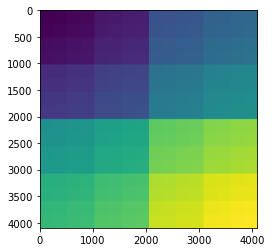

In [69]:
plt.imshow(matr)

In [15]:
pic_corners = np.zeros(matr.shape)

In [16]:
for x, y in corners_xy:
    pic_corners[circle(x, y, 17, shape=pic_corners.shape)] = 1

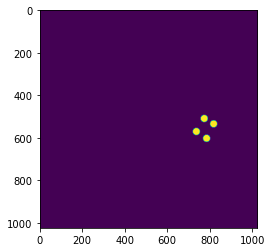

In [17]:
plt.imshow(pic_corners)

In [18]:
corners_xy = np.array(corners_xy)

In [19]:
corners_xy.shape

(4, 2)

In [20]:
print(corners_xy[:, 0].min(), corners_xy[:, 0].max())
print(corners_xy[:, 1].min(), corners_xy[:, 1].max())

509 602
734 815


In [21]:
map_size=128

In [70]:
one_circle = np.zeros(matr.shape, dtype=np.uint8)

In [71]:
sc = SkyCoord(ra=194.9551*u.degree, dec=28.0021*u.degree, frame='icrs')
circle_pix = hp.query_disc(f_nside, hp.ang2vec(sc.galactic.l.degree, sc.galactic.b.degree, 
                        lonlat=True), np.radians(0.2), nest=True, inclusive=True)

In [72]:
for pix in circle_pix:
    one_circle[mdict[pix]] = 1

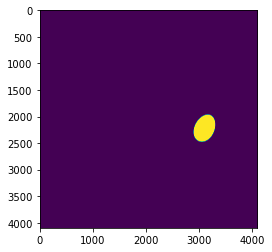

In [73]:
plt.imshow(one_circle)

In [74]:
circle_coords = [mdict[pix] for pix in circle_pix]

In [75]:
circle_coords = np.array(circle_coords)
circle_coords.shape

(158060, 2)

In [76]:
print(-(circle_coords[:, 0].min() - circle_coords[:, 0].max()))
print(-(circle_coords[:, 1].min() - circle_coords[:, 1].max()))

511
407


In [77]:
xmin = circle_coords[:, 0].min()
xmax = circle_coords[:, 0].max()
ymin = circle_coords[:, 1].min()
ymax = circle_coords[:, 1].max()

In [78]:
xmin, xmax, ymin, ymax, xmax - xmin, ymax - ymin

(1963, 2474, 2885, 3292, 511, 407)

In [79]:
xmax += 512 - (xmax - xmin)
ymax += 512 - (ymax - ymin)

In [80]:
xmin, xmax, ymin, ymax, xmax - xmin, ymax - ymin

(1963, 2475, 2885, 3397, 512, 512)

In [81]:
fin_matr = matr[xmin:xmax, ymin:ymax]

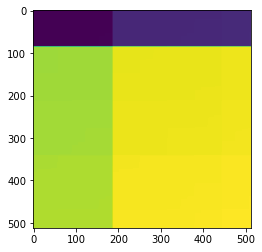

In [82]:
plt.imshow(fin_matr)

In [83]:
fin_dic_matr = matr2dict(fin_matr)
data_pic = np.zeros((512, 512, 3))

In [84]:
with fits.open('/home/rt2122/Data/coma_sweep/south/sweep-190p025-200p030.fits') as hdul:
    data = hdul[1].data
    flux = (data['FLUX_G'], data['FLUX_R'], data['FLUX_Z'])
    ra = data['RA']
    dec = data['DEC']
    pixels = radec2pix(ra, dec, f_nside)
    
    coords = []
    for pix in tqdm(pixels):
        if pix in fin_dic_matr:
            coords.append(fin_dic_matr[pix])
            
    for i in tqdm(range(len(coords))):
        x, y = coords[i]
        for k, ch in enumerate(flux):
            data_pic[x, y, k] = max(data_pic[x, y, k], ch[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


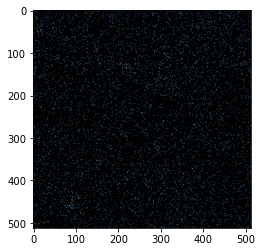

In [85]:
plt.imshow(data_pic)

In [47]:
keys = np.array([k for k in fin_dic_matr])

In [48]:
keys.max()

268253570

In [51]:
sd = {1:'s', 2:'c'}

In [52]:
sd[[1, 2]]

TypeError: unhashable type: 'list'

In [90]:
gdata_pix = gaussian(data_pic, 30) 

<ipython-input-90-3f6ba5e3f919>:1: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  gdata_pix = gaussian(data_pic, 30)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


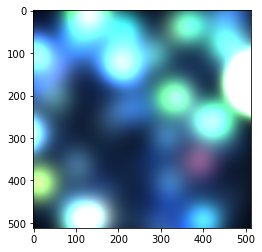

In [91]:
plt.imshow(gdata_pix)

In [111]:
centers = np.array([[194.8878, 28.0753],
    [195.0320, 27.9758],
    [194.8947, 27.9674]])
pix = radec2pix(centers[:, 0], centers[:, 1], f_nside)
cen_pic = np.zeros((512, 512, 1), dtype=np.int32)
for i in range(3):
    x, y = fin_dic_matr[pix[i]]
    circle_idx = circle(x, y, 40, shape=(512, 512, 1))
    cen_pic[circle_idx] = 1

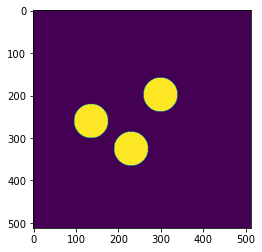

In [113]:
plt.imshow(cen_pic[:,:,0]*255)

In [96]:
cen_pic.max()

1